In [1]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


from plotting_helper import * 


figures_path = 'figures/'
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  


In [2]:
start_scope()

seed(42)

c_ca = 3.0


# VDP equations
##########################################

syn_eq = '''
    dvp/dt = (-vp + v)/tau_p : volt (clock-driven)
    dvm/dt = (-vm + v)/tau_m : volt (clock-driven)
    ds/dt = -s/tau_s : 1 (clock-driven)
    dw/dt = clip(eta * (A_p  * (vp - theta_p)/mV*int((vp - theta_p)/mV > 0 ) - A_d *(vm - theta_m)/mV * int((vm - theta_m)/mV > 0)) * s /tau_w * dt, (min_w - w), (max_w-w))/dt : 1 (clock-driven)
    tau_p : second
    tau_m : second
    tau_s : second
    A_p : 1
    A_d : 1
    theta_p : volt
    theta_m : volt
    g : 1
    eta : 1
    tau_w : second
    min_w : 1
    max_w : 1

'''




LIF_eqs = '''
    dv/dt = (vrest-v)/tau  - g_syn_i * (v-E_inh)/tau - g_syn_e * (v-E_exc)/tau + n_sigma*xi*tau**-0.5: volt (unless refractory)
    dg_syn_i/dt = -g_syn_i/tau_syn_e : 1
    dg_syn_e/dt = -g_syn_e/tau_syn_i : 1
    tau : second
    E_L: volt
    n_sigma: volt
    v_threshold: volt
    tau_syn : second
'''


LIF_reset = '''
    v = vrest
'''

def unpack_synparams(Syn, params): 
    Syn.g = params[0] 
    Syn.tau_s = params[1] *ms
    
    Syn.tau_m = params[2] *ms
    Syn.tau_p = params[3] * ms
    Syn.A_d = params[4]
    Syn.A_p = params[5]
    Syn.theta_m = params[6] *mV
    Syn.theta_p = params[7] * mV
    Syn.eta = params[8]
    Syn.min_w = params[9]
    Syn.max_w = params[10]
    Syn.tau_w = 1*ms
    
    return Syn

vrest = -79 * mV
tau_syn_e = 10 * ms 
tau_syn_i = 10 * ms 


# excitatory neurons

N_exc = 100
N_inh = 20
N_exc_in = 100

GE = NeuronGroup(N_exc, LIF_eqs, threshold='v > -49 * mV', 
                refractory=1*ms, method='euler', reset=LIF_reset)
GE.n_sigma = 0 * mV
GE.v = vrest
GE.tau = 10 * ms

# inhibitory neurons
GI = NeuronGroup(N_inh, LIF_eqs, threshold='v > -49 * mV', 
                refractory=1*ms, method='euler', reset=LIF_reset)
GI.n_sigma = 0 * mV
GI.v = vrest
GI.tau = 10 * ms 

# Inputs
##########################################

N_stim = 10
baseline = 5
on_rate = 100

#poisson input
IG = NeuronGroup(N_stim*N_stim, 'rates : Hz', threshold='rand()<rates*dt', refractory = 3 * ms)


@network_operation(dt=50*ms)
def stripes_bars(t):
    N = N_stim
    pattern = np.zeros((N,N))
    pattern[np.random.randint(0,N),:] = 1
    pattern[:,np.random.randint(0,N)] = 1
    new_rates = pattern.flatten()* on_rate * Hz
    IG.rates=new_rates


# Synapses
##########################################

# conductances
IG_g = 1/log(N_stim * N_stim)
IG_I_g = 0
EE_g = 1/log(N_exc)
IE_g = 1/log(N_exc)
EI_g = 4/log(N_inh)
II_g = 4/log(N_inh)

# reversal potentials
E_exc = 0 * mV 
E_inh = -80 * mV


w0_ee = 0.1
w0_ie = 0.5
w0_ii = 0.1
w0_ei = 0.5
w0_inp = 0.5
#[1/15, 15, 10, 7, 8.e-5, 2.5e-2,-75, -55,.1, 0,w0_ee * 4 ] was fineish
vdp_params_ee = [1/15, 15, 10, 7, 8.e-5, 2e-2,-75, -55,.1, 0,w0_ee * 4 ]
vdp_params_ie = [1/15, 15, 10, 7,8.e-5, 2e-2,-75, -55,.1, 0,w0_ie * 4 ]
vdp_params_ii = [1/15, 15, 10, 7,8.e-5, 2e-2,-75, -55,.1, 0,w0_ii * 4 ]
vdp_params_ei = [1/15, 15, 10, 7, 8.e-5, 2e-2,-75, -55,.1, 0,w0_ei * 4 ]
vdp_params_inp = [1/15, 15, 10, 7,8.e-5, 2e-2,-75, -55,.1, 0,w0_inp * 4 ]

S_EE = Synapses(GE, GE, syn_eq,
             on_pre='''
             g_syn_e += w * EE_g
             s += g
             ''', 
             method='euler')
S_EE.connect(condition='i != j', p=1)
S_EE = unpack_synparams(S_EE, vdp_params_ee)

S_IE = Synapses(GE, GI, syn_eq,
             on_pre='''
             g_syn_e += w * IE_g 
             s += g
             ''', method='euler')

S_IE.connect(p=1)
S_IE = unpack_synparams(S_IE, vdp_params_ie)


S_II = Synapses(GI, GI, syn_eq,
             on_pre='''
             g_syn_i += w * II_g
             s += g
             ''', method='euler')
S_II.connect(condition='i != j', p=1)
S_II = unpack_synparams(S_II, vdp_params_ii)


S_EI = Synapses(GI, GE, syn_eq,
             on_pre='''
             g_syn_i += w * EI_g 
             s += g
             ''', method='euler')

S_EI.connect(p=1)
S_EI = unpack_synparams(S_EI, vdp_params_ei)


S_IG = Synapses(IG, GE[:N_exc_in], syn_eq,
             on_pre='''
             g_syn_e += w * IG_g 
             s += g
             ''', method='euler')
S_IG.connect(p=1)
S_IG = unpack_synparams(S_IG, vdp_params_inp)

# initial weights
S_IG.w = 'w0_inp*rand()'
S_EE.w = 'w0_ee*rand()'
S_IE.w = 'w0_ie*rand()'
S_EI.w = 'w0_ei*rand()'
S_II.w = 'w0_ii*rand()'

# Monitors
##########################################

rate_monitor_E = PopulationRateMonitor(GE)
rate_monitor_I = PopulationRateMonitor(GI)
rate_mon_inp = PopulationRateMonitor(IG)

spike_monitor_E = SpikeMonitor(GE)
spike_monitor_I = SpikeMonitor(GI)
spike_monitor_IG = SpikeMonitor(IG)

M_IG = StateMonitor(S_IG, ['w'], record=np.arange(10), dt=10 * second)

INFO:root:creating /tmp/brian_flag_test_km6sonam/tmp
INFO:root:creating /tmp/brian_flag_test_km6sonam/tmp/brian_flag_test_km6sonam
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -c /tmp/brian_flag_test_km6sonam/flag_test.cpp -o /tmp/brian_flag_test_km6sonam/tmp/brian_flag_test_km6sonam/flag_test.o -w
INFO:root:creating /tmp/brian_flag_test_x_jwsixt/tmp
INFO:root:creating /tmp/brian_flag_test_x_jwsixt/tmp/brian_flag_test_x_jwsixt
INFO:root:gcc -pthread -B /disk/scratch/prubisch/miniconda/envs/brian_env/compiler_compat -Wl,--sysroot=/ -Wsign-compare -DNDEBUG -g -fwrapv -O3 -Wall -Wstrict-prototypes -fPIC -c /tmp/brian_flag_test_x_jwsixt/flag_test.cpp -o /tmp/brian_flag_test_x_jwsixt/tmp/brian_flag_test_x_jwsixt/flag_test.o -O3
INFO:root:creating /tmp/brian_flag_test_0gk8aykw/tmp
INFO:root:creating /tmp/brian_flag_test_0gk8aykw/tmp/brian_flag_test_0gk8aykw
INFO

In [8]:
#run(2000 * second, report = 'text') #2000s
restore(filename = '/disk/scratch/prubisch/brian_data/last_state_bars_and_stripes_network_meissner_bernard_decreased_LTP')
W_inp = np.full([N_stim**2, N_exc], np.nan)
W_inp[S_IG.i[:], S_IG.j[:]] = S_IG.w[:]

np.save('functional_sim_w/bars_and_stripes_W_meissnerbernard.npy', W_inp)
#run(1000 * second, report = 'text')

#store(filename = '/disk/scratch/prubisch/brian_data/last_state_bars_and_stripes_network_meissner_bernard_decreased_LTP')

In [4]:
#restore(filename = '/disk/scratch/prubisch/brian_data/last_state_bars_and_stripes_network_meissner_bernard')

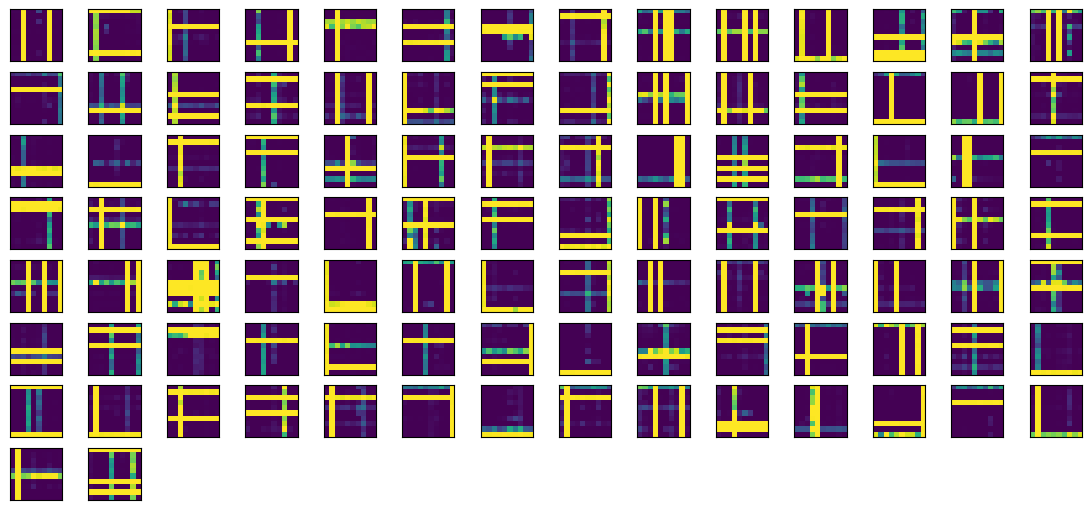

In [11]:
#these are all receptive fields of the first 140 neurons
minw = np.min(S_IG.w)
maxw = np.max(S_IG.w)
plt.figure(figsize=(14, 8))
for i  in range(min(N_exc_in, 140)):
    plt.subplot(10,14,i+1)
    # plt.imshow(S_IG.w[i*16:(i+1)*16].reshape((4,4)), vmin=0, vmax=1)
    #minw = np.min(S_IG.w[i::N_exc_in])
    #maxw = np.max(S_IG.w[i::N_exc_in])
    plt.imshow(S_IG.w[i::N_exc_in].reshape((N_stim,N_stim)), vmin = minw, vmax = maxw)#, vmin=0, vmax=1)
    # plt.imshow(S_IG.w[i::60].reshape((6,6)))#, vmin=0, vmax=1)

    plt.xticks(())
    plt.yticks(())


INFO       width adjusted from 1. s to 1.0001 s [brian2.monitors.ratemonitor.adjusted_width]


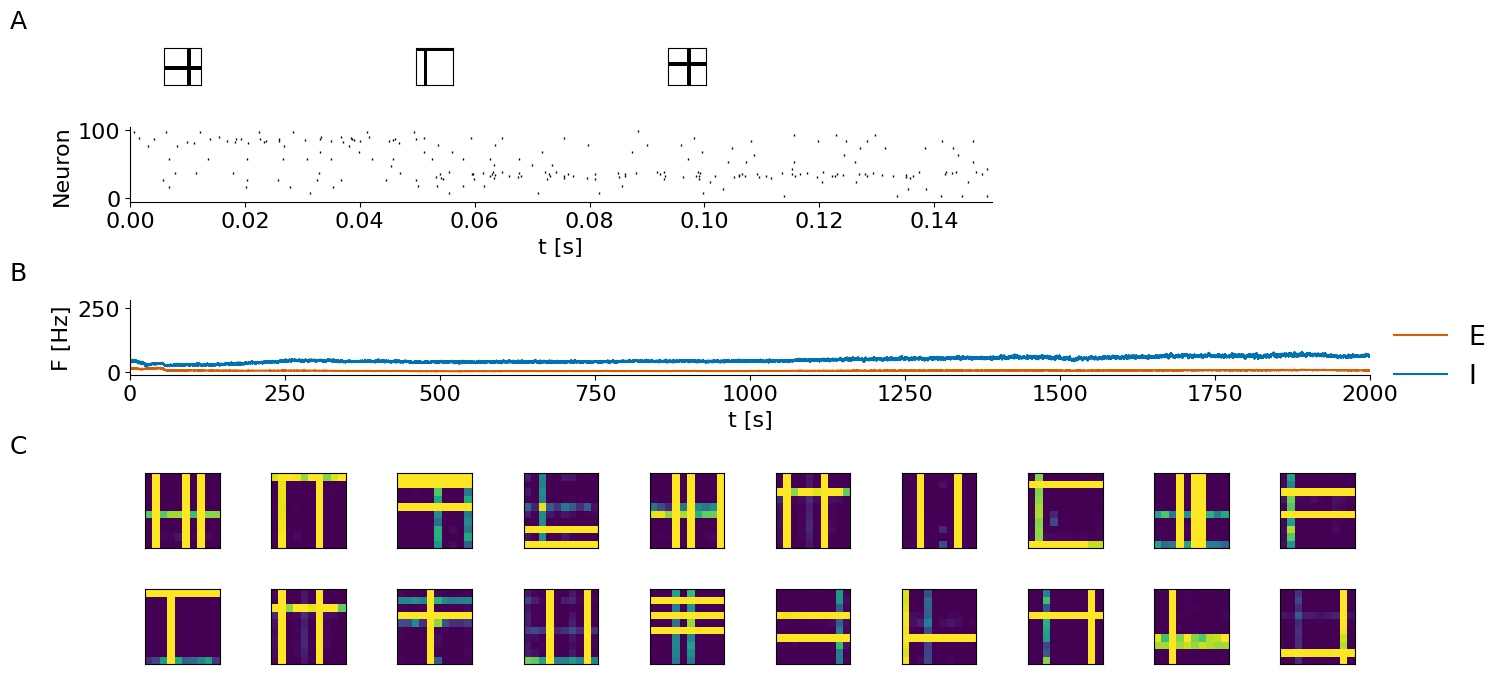

In [6]:
 #Do the figure

layout = '''
    AAAAAAAAAA
    AAAAAAAAAA
    AAAAAAAAAA
    BBBBBBBBBB
    BBBBBBBBBB
    CCCCCCCCCC
    CCCCCCCCCC
    '''

fig = plt.figure(figsize=(16, 8))

height_ratios = [0.5,1,0.2,1,0.2,1,1]
width_ratios = [1,1,1,1,1,1,1,1,1,1]

specs, gs = panel_specs(layout, fig=fig)
gs.set_height_ratios(height_ratios)
gs.set_width_ratios(width_ratios)
gs.hspace=0.8
axes = {}
for letter in 'ABC':
    axes[letter] = ax = fig.add_subplot(specs[letter])
label_panels(axes, letters='ABC', postfix='', offset_left=1.2)
for a in list('ABC'):
    axes[a].set_axis_off()

    
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']  

#plot bars and stripes example image
ax = fig.add_subplot(gs[0,0])
input_pattern = np.zeros([N_stim,N_stim])
input_pattern[4,:] = 1.0
input_pattern[:,6] = 1.0
ax.imshow(input_pattern, origin = 'lower', cmap = 'Greys', vmin = 0, vmax = 1)
ax.set_xticks(())
ax.set_yticks(())

ax = fig.add_subplot(gs[0,2])
input_pattern = np.zeros([N_stim,N_stim])
input_pattern[9,:] = 1.0
input_pattern[:,2] = 1.0
ax.imshow(input_pattern,  origin = 'lower',cmap = 'Greys', vmin = 0, vmax = 1)
ax.set_xticks(())
ax.set_yticks(())

ax = fig.add_subplot(gs[0,4])
input_pattern = np.zeros([N_stim,N_stim])
input_pattern[5,:] = 1.0
input_pattern[:,5] = 1.0
ax.imshow(input_pattern,  origin = 'lower',cmap = 'Greys', vmin = 0, vmax = 1)
ax.set_xticks(())
ax.set_yticks(())

#plot the bars and stripes spikes
ax = fig.add_subplot(gs[1,0:7])
plt.plot(spike_monitor_IG.t / second, spike_monitor_IG.i , "|", color='k', ms=1)
ax.set_xlabel('t [s]')
ax.set_ylabel('Neuron')
ax.set_xlim(0,0.15)
clear_axes(ax)

#plot the rate activites
ax = fig.add_subplot(gs[3,0:10])
rate_window = 1000
plt.plot(rate_monitor_E.t / second, rate_monitor_E.smooth_rate(window='flat', width=rate_window*ms) / Hz, color = palette[2], label = 'E')
plt.plot(rate_monitor_I.t / second, rate_monitor_I.smooth_rate(window='flat', width=rate_window*ms) / Hz, color = palette[0], label = 'I')
ax.set_xlabel('t [s]')
ax.set_ylabel('F [Hz]')
ax.legend( bbox_to_anchor=(1.0, 1.0), loc='upper left',  frameon = False)
ax.set_xlim(0,2000)
clear_axes(ax)

#plot receptive fields of neurons with different features, maybe resort them... 
to_be_plotted = [9,10,11,20,22,23,0,1,8,24,25,23,32,92,37,5,2,3,4,7,12]
for i  in range(10):
    for j in range(2): 
        ax = fig.add_subplot(gs[5+j,i])
        minw = np.min(S_IG.w[to_be_plotted[j*10 + i]::N_exc_in])
        maxw = np.max(S_IG.w[to_be_plotted[j*10 + i]::N_exc_in])
        ax.imshow(S_IG.w[to_be_plotted[j*10 + i]::N_exc_in].reshape((N_stim,N_stim)), origin = 'lower', vmin = minw, vmax = maxw)#, vmin=0, vmax=1)

        ax.set_xticks(())
        ax.set_yticks(())

#plt.savefig(figures_path+'meissner_bernard_bars_and_stripes.pdf', bbox_inches='tight')
plt.show()

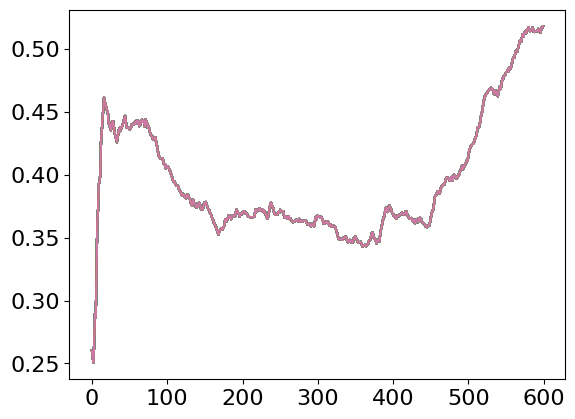

In [7]:
for i in range(N_exc):
    plt.errorbar(np.arange(M_IG.w.shape[1]),np.mean(M_IG.w, axis =0))#, yerr = np.std(collect_ws[:,:,i], axis =1))
#plt.plot(M_IG.w[:,1])
plt.show()

In [8]:
####trying to calculate a score for the degree of ICA learned here
from sklearn.metrics.pairwise import cosine_similarity

stimulis = np.zeros([2,N_stim,N_stim**2])
for i in range(N_stim):
    stim = np.zeros([N_stim,N_stim])
    stim[i,:] = 1
    stimulis[0,i,:] = stim.flatten() 
    stim = np.zeros([N_stim,N_stim])
    stim[:,i] = 1
    stimulis[1,i,:] = stim.flatten() 
    
def ICA_score(weights, N_exc , stims): 
    #rfs are reshape to be the same size as stims
    #stims: (2,n,n*n), first bar or strips 
    I_s = np.zeros([N_exc])
    
    for ind in range(N_exc):
        #we can also define the rf outside of the function, if unsafe that this is the correct splicing
        rf = weights[ind::N_exc]
        #bar score
        b_sc= cosine_similarity(rf.reshape(1,-1), stims[0])
        #stripe score
        s_sc= cosine_similarity(rf.reshape(1,-1), stims[1])
        I_s[ind] = np.sum(b_sc) * np.max(b_sc)  + np.sum(s_sc) * np.max(s_sc)
        #a score of 1.1 means that the cell encodes exactly 1 strip or bar
        
    return I_s

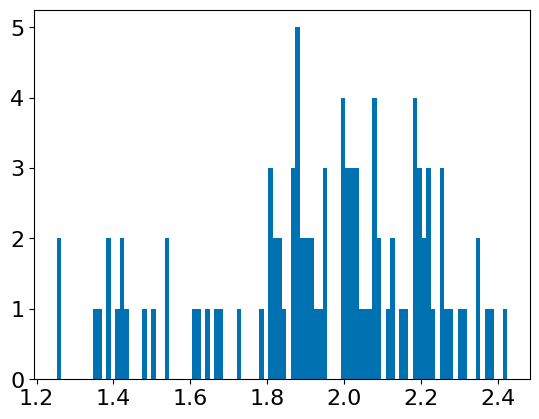

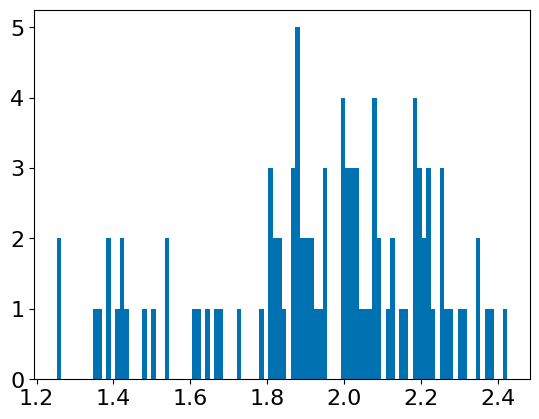

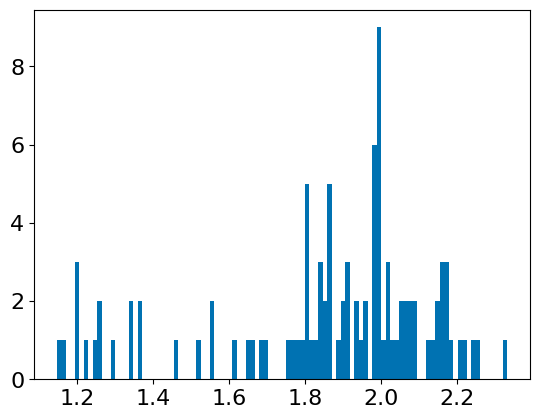

In [14]:
ICA_scores = ICA_score(S_IG.w[:]/maxw, N_exc_in, stimulis)

plt.hist(ICA_scores, bins = 100)
plt.show()

ICA_scores = ICA_score(S_IG.w[:], N_exc_in, stimulis)

plt.hist(ICA_scores, bins = 100)
plt.show()

#cleaned
cleaned_w = S_IG.w[:] * (S_IG.w[:] > 0.5)
ICA_scores = ICA_score(cleaned_w, N_exc_in, stimulis)

plt.hist(ICA_scores, bins = 100)
plt.show()

In [10]:
stimulis = np.zeros([2,10,10*10])
test_stimuli = np.zeros([34,10*10])
for i in range(10):
    stim = np.zeros([10,10])
    stim[i,:] = 1
    stimulis[0,i,:] = stim.flatten() 
    test_stimuli[i,:] = stim.flatten()
    stim = np.zeros([10,10])
    stim[:,i] = 1
    stimulis[1,i,:] = stim.flatten() 
    test_stimuli[i+10,:] = test_stimuli[i,:] + stim.flatten()
    test_stimuli[i+20,:] = test_stimuli[i+5,:] + stim.flatten()
    
  
test_stimuli[-3,:] = 1 
test_stimuli[-2,np.arange(0,100,10)+np.arange(0,10,1)] = 1 
test_stimuli[-1,np.random.randint(100,size = 5)] = 1
    
print(ICA_score(test_stimuli, stimulis))

TypeError: ICA_score() missing 1 required positional argument: 'stims'

In [ ]:
for i in range(test_stimuli.shape[0]): 
    plt.imshow(test_stimuli[i].reshape(10,10))
    plt.show()

In [15]:
M_IG.t

<statemonitor.t: array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.4